# Zernike Polynomials Tutorial

This tutorial covers the Zernike polynomial functions in Janssen for optical aberration modeling.

## Overview

Zernike polynomials form a complete orthogonal basis over the unit circle and are widely used in optics to describe wavefront aberrations. They are particularly useful because:

1. They are orthogonal over the unit circle (pupil)
2. Each polynomial corresponds to a classical optical aberration
3. They provide a systematic way to decompose and analyze wavefront errors

## Indexing Conventions

Zernike polynomials can be indexed in two ways:

- **(n, m) indices**: `n` is the radial order, `m` is the azimuthal frequency
- **Noll index (j)**: A single index starting from j=1 (piston)

| Noll j | (n, m) | Name |
|--------|--------|------|
| 1 | (0, 0) | Piston |
| 2 | (1, 1) | Tilt X |
| 3 | (1, -1) | Tilt Y |
| 4 | (2, 0) | Defocus |
| 5 | (2, -2) | Astigmatism (oblique) |
| 6 | (2, 2) | Astigmatism (vertical) |
| 7 | (3, -1) | Coma Y |
| 8 | (3, 1) | Coma X |
| 9 | (3, -3) | Trefoil Y |
| 10 | (3, 3) | Trefoil X |
| 11 | (4, 0) | Spherical |

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as mpgs
from janssen.optics import (
    zernike_polynomial,
    zernike_radial,
    noll_to_nm,
    nm_to_noll,
    compute_phase_from_coeffs,
    phase_rms,
    
)

# Configure matplotlib for publication figures
# IEEE two-column format: 7" wide, 10pt font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['TeX Gyre Heros']
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'TeX Gyre Heros'
plt.rcParams['mathtext.it'] = 'TeX Gyre Heros:italic'
plt.rcParams['mathtext.bf'] = 'TeX Gyre Heros:bold'

# Set 10pt font for all text elements
plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['figure.titlesize'] = 7

## Setup: Coordinate Grids

Zernike polynomials are defined on the unit circle using polar coordinates (rho, theta).

In [2]:
# Create coordinate grids
grid_size = 256
x = jnp.linspace(-1.2, 1.2, grid_size)
y = jnp.linspace(-1.2, 1.2, grid_size)
xx, yy = jnp.meshgrid(x, y)

# Convert to polar coordinates
rho = jnp.sqrt(xx**2 + yy**2)
theta = jnp.arctan2(yy, xx)

# Mask for unit circle visualization
circle_mask = rho <= 1.0

## 1. Index Conversion Functions

Convert between Noll indexing and (n, m) indices.

In [3]:
# Convert Noll index to (n, m)
print("Noll to (n, m) conversion:")
print("-" * 30)
for j in range(1, 16):
    n, m = noll_to_nm(j)
    print(f"j={j:2d} -> (n={n}, m={m:2d})")

Noll to (n, m) conversion:
------------------------------
j= 1 -> (n=0, m= 0)
j= 2 -> (n=1, m= 1)
j= 3 -> (n=1, m=-1)
j= 4 -> (n=2, m= 0)
j= 5 -> (n=2, m=-2)
j= 6 -> (n=2, m= 2)
j= 7 -> (n=3, m=-1)
j= 8 -> (n=3, m= 1)
j= 9 -> (n=3, m=-3)
j=10 -> (n=3, m= 3)
j=11 -> (n=4, m= 0)
j=12 -> (n=4, m= 2)
j=13 -> (n=4, m=-2)
j=14 -> (n=4, m= 4)
j=15 -> (n=4, m=-4)


In [4]:
# Convert (n, m) to Noll index
print("\n(n, m) to Noll conversion:")
print("-" * 30)
test_cases = [(0, 0), (1, 1), (1, -1), (2, 0), (2, 2), (2, -2), (3, 1), (3, -1), (4, 0)]
for n, m in test_cases:
    j = nm_to_noll(n, m)
    print(f"(n={n}, m={m:2d}) -> j={j}")


(n, m) to Noll conversion:
------------------------------
(n=0, m= 0) -> j=1
(n=1, m= 1) -> j=2
(n=1, m=-1) -> j=3
(n=2, m= 0) -> j=4
(n=2, m= 2) -> j=6
(n=2, m=-2) -> j=5
(n=3, m= 1) -> j=8
(n=3, m=-1) -> j=7
(n=4, m= 0) -> j=11


## 2. Radial Polynomials

The radial component $R_n^{|m|}(\rho)$ depends only on the radial coordinate.

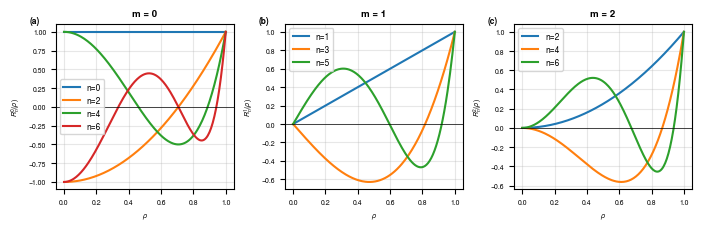

In [5]:
# Plot radial polynomials for different (n, m) combinations
rho_1d = jnp.linspace(0, 1, 200)

fig, axes = plt.subplots(1, 3, figsize=(7, 2.3))

# m = 0 (rotationally symmetric)
ax = axes[0]
for n in [0, 2, 4, 6]:
    R = zernike_radial(rho_1d, n, 0)
    ax.plot(rho_1d, R, label=f"n={n}", linewidth=1.5)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$R_n^0(\rho)$")
ax.set_title("m = 0")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.text(-0.15, 1.05, '(a)', transform=ax.transAxes, fontweight='bold', va='top')

# m = 1
ax = axes[1]
for n in [1, 3, 5]:
    R = zernike_radial(rho_1d, n, 1)
    ax.plot(rho_1d, R, label=f"n={n}", linewidth=1.5)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$R_n^1(\rho)$")
ax.set_title("m = 1")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.text(-0.15, 1.05, '(b)', transform=ax.transAxes, fontweight='bold', va='top')

# m = 2
ax = axes[2]
for n in [2, 4, 6]:
    R = zernike_radial(rho_1d, n, 2)
    ax.plot(rho_1d, R, label=f"n={n}", linewidth=1.5)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$R_n^2(\rho)$")
ax.set_title("m = 2")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.text(-0.15, 1.05, '(c)', transform=ax.transAxes, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('Figures/zernike_radial_polynomials.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_radial_polynomials.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 3. Individual Zernike Polynomials

Generate and visualize individual Zernike polynomials using either (n, m) or Noll indexing.

In [6]:
def plot_zernike(rho, theta, n, m, ax, title=None):
    """Plot a single Zernike polynomial."""
    Z = zernike_polynomial(rho, theta, n, m, normalize=True)
    # Mask outside unit circle for display
    Z_masked = jnp.where(rho <= 1.0, Z, jnp.nan)
    
    vmax = jnp.nanmax(jnp.abs(Z_masked))
    im = ax.imshow(Z_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax, extent=[-1.2, 1.2, -1.2, 1.2])
    ax.set_aspect("equal")
    ax.axis("off")
    
    if title is None:
        j = nm_to_noll(n, m)
        title = f"Z{j} (n={n}, m={m})"
    ax.set_title(title)
    return im

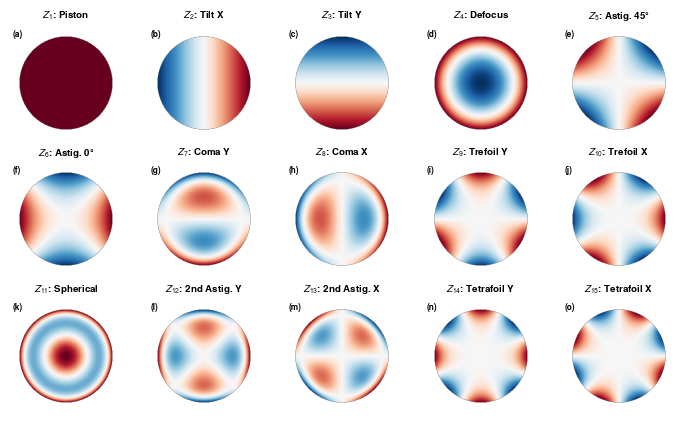

In [7]:
# Plot first 15 Zernike polynomials (Noll ordering)
fig, axes = plt.subplots(3, 5, figsize=(7, 4.2))

aberration_names = {
    1: "Piston",
    2: "Tilt X",
    3: "Tilt Y",
    4: "Defocus",
    5: "Astig. 45°",
    6: "Astig. 0°",
    7: "Coma Y",
    8: "Coma X",
    9: "Trefoil Y",
    10: "Trefoil X",
    11: "Spherical",
    12: "2nd Astig. Y",
    13: "2nd Astig. X",
    14: "Tetrafoil Y",
    15: "Tetrafoil X",
}

subfig_labels = 'abcdefghijklmno'

for idx, j in enumerate(range(1, 16)):
    ax = axes.flat[idx]
    n, m = noll_to_nm(j)
    n, m = int(n), int(m)
    name = aberration_names.get(j, "")
    title = f"$Z_{{{j}}}$: {name}"
    plot_zernike(rho, theta, n, m, ax, title=title)
    ax.text(0.02, 0.98, f'({subfig_labels[idx]})', transform=ax.transAxes, 
            fontweight='bold', va='top', color='black')

plt.tight_layout()
plt.savefig('Figures/zernike_first_15_modes.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_first_15_modes.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 4. Zernike Pyramid

Zernike polynomials organized by radial order n and azimuthal frequency m.

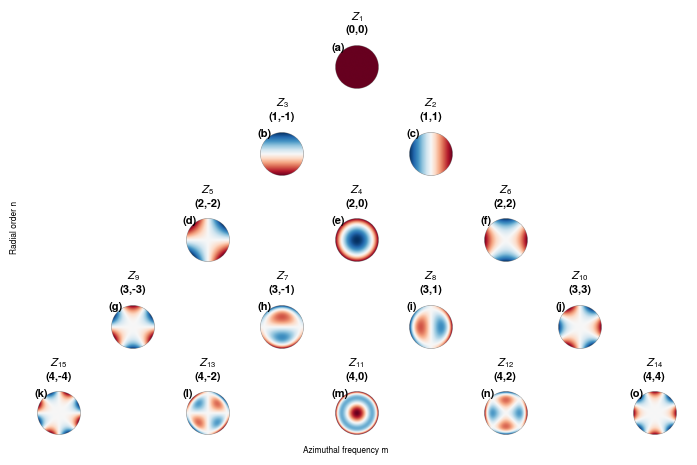

In [8]:
# Create Zernike pyramid up to n=4
max_n = 4

fig, axes = plt.subplots(max_n + 1, 2 * max_n + 1, figsize=(7, 4.7))

# Hide all axes initially
for ax_row in axes:
    for ax in ax_row:
        ax.axis("off")

# Plot Zernike polynomials in pyramid arrangement
subfig_idx = 0
subfig_labels = 'abcdefghijklmno'

for n in range(max_n + 1):
    m_values = list(range(-n, n + 1, 2))
    
    for m in m_values:
        col = max_n + m
        ax = axes[n, col]
        
        Z = zernike_polynomial(rho, theta, n, m, normalize=True)
        Z_masked = jnp.where(rho <= 1.0, Z, jnp.nan)
        
        vmax = jnp.nanmax(jnp.abs(Z_masked))
        if vmax > 0:
            ax.imshow(Z_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
        else:
            ax.imshow(Z_masked, cmap="RdBu_r")
        
        j = nm_to_noll(n, m)
        ax.set_title(f"$Z_{{{j}}}$\n({n},{m})", fontsize=8)
        ax.axis("off")
        ax.text(0.02, 0.98, f'({subfig_labels[subfig_idx]})', transform=ax.transAxes, 
                fontsize=8, fontweight='bold', va='top', color='black')
        subfig_idx += 1

# Add labels
fig.text(0.02, 0.5, "Radial order n", va="center", rotation="vertical")
fig.text(0.5, 0.02, "Azimuthal frequency m", ha="center")

plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
plt.savefig('Figures/zernike_pyramid.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_pyramid.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 5. Common Optical Aberrations

Janssen provides convenience functions for common aberrations.

In [9]:
# Physical coordinate setup
pupil_radius = 1.0  # meters (normalized)
physical_extent = 1.2 * pupil_radius

x_phys = jnp.linspace(-physical_extent, physical_extent, grid_size)
y_phys = jnp.linspace(-physical_extent, physical_extent, grid_size)
xx_phys, yy_phys = jnp.meshgrid(x_phys, y_phys)

# Mask for visualization
rho_phys = jnp.sqrt(xx_phys**2 + yy_phys**2) / pupil_radius

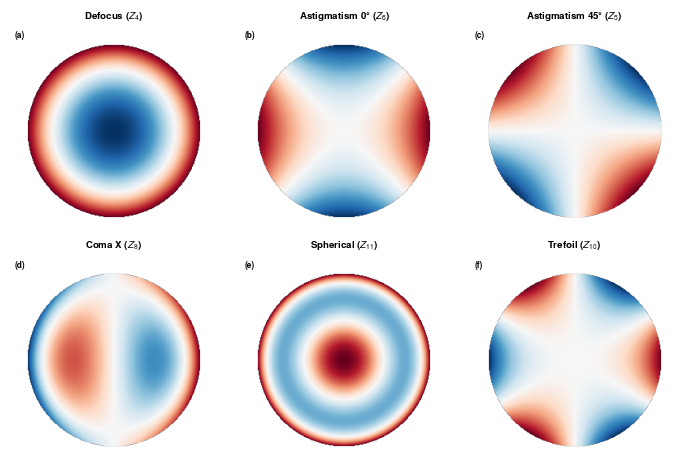

In [10]:
# Common optical aberrations
def plot_aberration(phase, title, ax):
    """Plot an aberration phase map."""
    phase_masked = jnp.where(rho_phys <= 1.0, phase, jnp.nan)
    vmax = jnp.nanmax(jnp.abs(phase_masked))
    if vmax > 0:
        im = ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    else:
        im = ax.imshow(phase_masked, cmap="RdBu_r")
    ax.set_title(title)
    ax.axis("off")
    return im


def make_aberration(n, m, amplitude):
    """Generate aberration phase using zernike_polynomial directly."""
    Z = zernike_polynomial(rho_phys, jnp.arctan2(yy_phys, xx_phys), n, m, normalize=True)
    return 2 * jnp.pi * amplitude * Z


fig, axes = plt.subplots(2, 3, figsize=(7, 4.7))

# Defocus (Z4): n=2, m=0
phase_defocus = make_aberration(2, 0, 1.0)
plot_aberration(phase_defocus, "Defocus ($Z_4$)", axes[0, 0])
axes[0, 0].text(0.02, 0.98, '(a)', transform=axes[0, 0].transAxes, 
                fontweight='bold', va='top', color='black')

# Vertical Astigmatism (Z6): n=2, m=2
phase_astig = make_aberration(2, 2, 1.0)
plot_aberration(phase_astig, "Astigmatism 0° ($Z_6$)", axes[0, 1])
axes[0, 1].text(0.02, 0.98, '(b)', transform=axes[0, 1].transAxes, 
                fontweight='bold', va='top', color='black')

# Oblique Astigmatism (Z5): n=2, m=-2
phase_astig_45 = make_aberration(2, -2, 1.0)
plot_aberration(phase_astig_45, "Astigmatism 45° ($Z_5$)", axes[0, 2])
axes[0, 2].text(0.02, 0.98, '(c)', transform=axes[0, 2].transAxes, 
                fontweight='bold', va='top', color='black')

# Horizontal Coma (Z8): n=3, m=1
phase_coma = make_aberration(3, 1, 1.0)
plot_aberration(phase_coma, "Coma X ($Z_8$)", axes[1, 0])
axes[1, 0].text(0.02, 0.98, '(d)', transform=axes[1, 0].transAxes, 
                fontweight='bold', va='top', color='black')

# Spherical Aberration (Z11): n=4, m=0
phase_spherical = make_aberration(4, 0, 1.0)
plot_aberration(phase_spherical, "Spherical ($Z_{11}$)", axes[1, 1])
axes[1, 1].text(0.02, 0.98, '(e)', transform=axes[1, 1].transAxes, 
                fontweight='bold', va='top', color='black')

# Trefoil (Z10): n=3, m=3
phase_trefoil = make_aberration(3, 3, 1.0)
plot_aberration(phase_trefoil, "Trefoil ($Z_{10}$)", axes[1, 2])
axes[1, 2].text(0.02, 0.98, '(f)', transform=axes[1, 2].transAxes, 
                fontweight='bold', va='top', color='black')

plt.tight_layout()
plt.savefig('Figures/zernike_common_aberrations.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_common_aberrations.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 6. Generating Aberrations from Coefficients

Combine multiple Zernike modes to create complex wavefront aberrations.

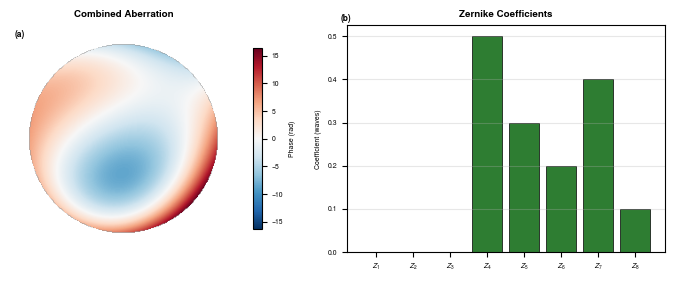

In [11]:
# Generate combined aberration by summing individual Zernike modes
theta_phys = jnp.arctan2(yy_phys, xx_phys)

def generate_aberration_manual(rho, theta, noll_coeffs):
    """Generate aberration from Noll-indexed coefficients."""
    phase = jnp.zeros_like(rho)
    for j, coeff in enumerate(noll_coeffs, 1):
        if coeff != 0:
            n, m = noll_to_nm(j)
            n, m = int(n), int(m)
            Z = zernike_polynomial(rho, theta, n, m, normalize=True)
            phase = phase + coeff * Z
    return 2 * jnp.pi * phase

# Example: Combination of defocus + astigmatism + coma
coefficients_noll = [
    0.0,   # j=1: Piston
    0.0,   # j=2: Tilt X
    0.0,   # j=3: Tilt Y
    0.5,   # j=4: Defocus
    0.3,   # j=5: Astigmatism (oblique)
    0.2,   # j=6: Astigmatism (vertical)
    0.4,   # j=7: Coma Y
    0.1,   # j=8: Coma X
]

phase_combined = generate_aberration_manual(rho_phys, theta_phys, coefficients_noll)

fig, axes = plt.subplots(1, 2, figsize=(7, 2.8))

# Plot combined aberration
phase_masked = jnp.where(rho_phys <= 1.0, phase_combined, jnp.nan)
vmax = jnp.nanmax(jnp.abs(phase_masked))
im = axes[0].imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
axes[0].set_title("Combined Aberration")
axes[0].axis("off")
axes[0].text(0.02, 0.98, '(a)', transform=axes[0].transAxes, 
             fontweight='bold', va='top', color='black')
plt.colorbar(im, ax=axes[0], label="Phase (rad)", shrink=0.8)

# Bar plot of coefficients with green/orange colors
labels = ["$Z_1$", "$Z_2$", "$Z_3$", "$Z_4$", "$Z_5$", "$Z_6$", "$Z_7$", "$Z_8$"]
COLOR_POS = '#2E7D32'
COLOR_NEG = '#E65100'
colors = [COLOR_POS if c >= 0 else COLOR_NEG for c in coefficients_noll]
colors = ["gray" if c == 0 else colors[i] for i, c in enumerate(coefficients_noll)]
axes[1].bar(range(len(coefficients_noll)), coefficients_noll, color=colors, edgecolor='black', linewidth=0.5)
axes[1].set_xticks(range(len(coefficients_noll)))
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Coefficient (waves)")
axes[1].set_title("Zernike Coefficients")
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=0, color='k', linewidth=0.5)
axes[1].text(-0.02, 1.05, '(b)', transform=axes[1].transAxes, 
             fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('Figures/zernike_combined_aberration.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_combined_aberration.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

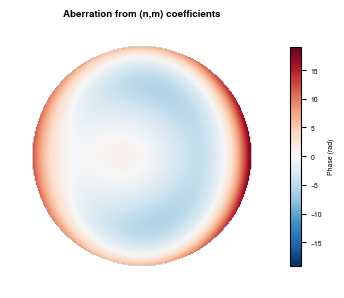

In [12]:
# Generate aberration using (n, m) indices directly
nm_specs = [
    (2, 0, 0.5),   # Defocus
    (2, 2, 0.3),   # Astigmatism
    (4, 0, 0.4),   # Spherical
    (3, 1, 0.2),   # Coma
]

phase_nm = jnp.zeros_like(rho_phys)
for n, m, coeff in nm_specs:
    Z = zernike_polynomial(rho_phys, theta_phys, n, m, normalize=True)
    phase_nm = phase_nm + coeff * Z
phase_nm = 2 * jnp.pi * phase_nm

# Visualize (single column width = 3.5")
fig, ax = plt.subplots(figsize=(3.5, 3))
phase_masked = jnp.where(rho_phys <= 1.0, phase_nm, jnp.nan)
vmax = jnp.nanmax(jnp.abs(phase_masked))
im = ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
ax.set_title("Aberration from (n,m) coefficients")
ax.axis("off")
plt.colorbar(im, ax=ax, label="Phase (rad)", shrink=0.8)
plt.tight_layout()
plt.savefig('Figures/zernike_nm_aberration.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_nm_aberration.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 7. Effect of Varying Coefficients

Visualize how aberrations change with varying amplitude.

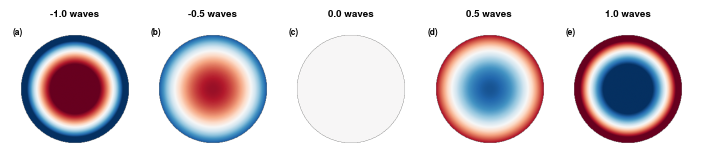

In [13]:
# Show defocus at different amplitudes
amplitudes = [-1.0, -0.5, 0.0, 0.5, 1.0]
subfig_labels = 'abcde'

fig, axes = plt.subplots(1, 5, figsize=(7, 1.7))

for idx, (ax, amp) in enumerate(zip(axes, amplitudes)):
    phase = make_aberration(2, 0, amp)  # n=2, m=0 for defocus
    phase_masked = jnp.where(rho_phys <= 1.0, phase, jnp.nan)
    ax.imshow(phase_masked, cmap="RdBu_r", vmin=-2*jnp.pi, vmax=2*jnp.pi)
    ax.set_title(f"{amp} waves")
    ax.axis("off")
    ax.text(0.02, 0.98, f'({subfig_labels[idx]})', transform=ax.transAxes, 
            fontweight='bold', va='top', color='black')

plt.tight_layout()
plt.savefig('Figures/zernike_defocus_amplitudes.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_defocus_amplitudes.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

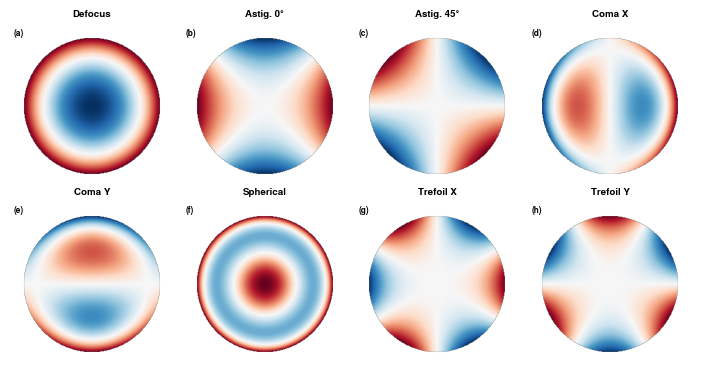

In [14]:
# Compare different aberration modes at same amplitude
fig, axes = plt.subplots(2, 4, figsize=(7, 3.7))

# (name, n, m)
aberrations = [
    ("Defocus", 2, 0),
    ("Astig. 0°", 2, 2),
    ("Astig. 45°", 2, -2),
    ("Coma X", 3, 1),
    ("Coma Y", 3, -1),
    ("Spherical", 4, 0),
    ("Trefoil X", 3, 3),
    ("Trefoil Y", 3, -3),
]

subfig_labels = 'abcdefgh'

for idx, (ax, (name, n, m)) in enumerate(zip(axes.flat, aberrations)):
    phase = make_aberration(n, m, 1.0)
    phase_masked = jnp.where(rho_phys <= 1.0, phase, jnp.nan)
    vmax = jnp.nanmax(jnp.abs(phase_masked))
    ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    ax.set_title(name)
    ax.axis("off")
    ax.text(0.02, 0.98, f'({subfig_labels[idx]})', transform=ax.transAxes, 
            fontweight='bold', va='top', color='black')

plt.tight_layout()
plt.savefig('Figures/zernike_aberration_modes.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_aberration_modes.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 8. Orthogonality of Zernike Polynomials

Zernike polynomials are orthogonal over the unit circle. The inner product of two different normalized Zernike polynomials is zero.

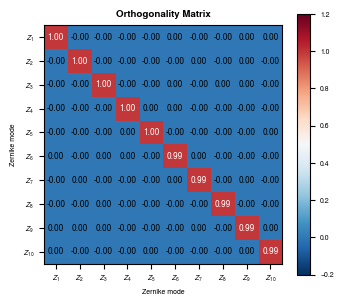

Diagonal values (should be ~1.0):
['0.996', '0.995', '0.995', '0.995', '0.996', '0.995', '0.995', '0.995', '0.995', '0.995']


In [15]:
# Create finer grid for numerical integration
n_points = 512
x_fine = jnp.linspace(-1, 1, n_points)
y_fine = jnp.linspace(-1, 1, n_points)
xx_fine, yy_fine = jnp.meshgrid(x_fine, y_fine)
rho_fine = jnp.sqrt(xx_fine**2 + yy_fine**2)
theta_fine = jnp.arctan2(yy_fine, xx_fine)

# Compute inner products for first 10 Zernike modes
n_modes = 10
inner_products = jnp.zeros((n_modes, n_modes))

# Generate all Zernike polynomials
zernike_modes = []
for j in range(1, n_modes + 1):
    n, m = noll_to_nm(j)
    n, m = int(n), int(m)
    Z = zernike_polynomial(rho_fine, theta_fine, n, m, normalize=True)
    Z = jnp.where(rho_fine <= 1.0, Z, 0.0)
    zernike_modes.append(Z)

# Compute inner product matrix
dx = 2.0 / n_points
area_element = dx * dx
pupil_area = jnp.pi

inner_product_matrix = []
for i, Zi in enumerate(zernike_modes):
    row = []
    for j, Zj in enumerate(zernike_modes):
        product = Zi * Zj
        integral = jnp.sum(product) * area_element / pupil_area
        row.append(float(integral))
    inner_product_matrix.append(row)

inner_product_matrix = jnp.array(inner_product_matrix)

# Plot (single column width = 3.5")
fig, ax = plt.subplots(figsize=(3.5, 3.5))
im = ax.imshow(inner_product_matrix, cmap="RdBu_r", vmin=-0.2, vmax=1.2)
ax.set_xticks(range(n_modes))
ax.set_yticks(range(n_modes))
ax.set_xticklabels([f"$Z_{{{j}}}$" for j in range(1, n_modes + 1)])
ax.set_yticklabels([f"$Z_{{{j}}}$" for j in range(1, n_modes + 1)])
ax.set_xlabel("Zernike mode")
ax.set_ylabel("Zernike mode")
ax.set_title("Orthogonality Matrix")
plt.colorbar(im, ax=ax, shrink=0.8)

# Annotate values
for i in range(n_modes):
    for j in range(n_modes):
        val = inner_product_matrix[i, j]
        color = "white" if abs(val) > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=6)

plt.tight_layout()
plt.savefig('Figures/zernike_orthogonality.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_orthogonality.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print("Diagonal values (should be ~1.0):")
print([f"{inner_product_matrix[i,i]:.3f}" for i in range(n_modes)])

## 9. Random Aberrations

Generate random wavefront aberrations by sampling Zernike coefficients.

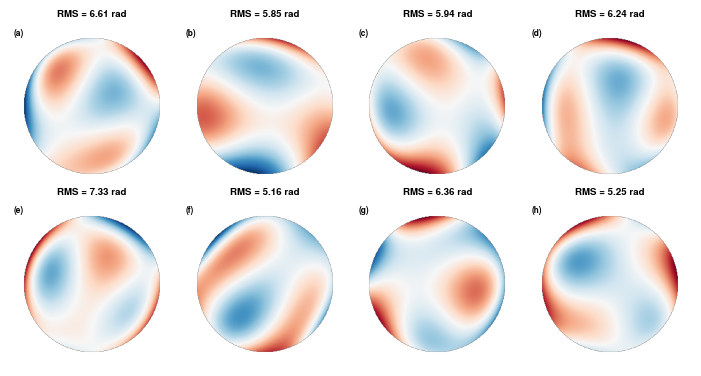

In [16]:
# Generate random aberrations
key = jax.random.PRNGKey(42)

fig, axes = plt.subplots(2, 4, figsize=(7, 3.7))
subfig_labels = 'abcdefgh'

for idx, ax in enumerate(axes.flat):
    key, subkey = jax.random.split(key)
    
    # Random coefficients for Noll indices 4-15 (skip piston and tilts)
    n_coeffs = 15
    random_coeffs_plot = jax.random.normal(subkey, (n_coeffs - 3,)) * 0.3
    
    # Build phase by summing individual modes
    phase = jnp.zeros_like(rho_phys)
    for i, coeff in enumerate(random_coeffs_plot):
        j = i + 4  # Start from j=4 (defocus)
        n, m = noll_to_nm(j)
        n, m = int(n), int(m)
        Z = zernike_polynomial(rho_phys, theta_phys, n, m, normalize=True)
        phase = phase + coeff * Z
    phase = 2 * jnp.pi * phase
    
    phase_masked = jnp.where(rho_phys <= 1.0, phase, jnp.nan)
    
    vmax = jnp.nanmax(jnp.abs(phase_masked))
    ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    
    # Calculate RMS
    rms = jnp.sqrt(jnp.nanmean(phase_masked**2))
    ax.set_title(f"RMS = {rms:.2f} rad")
    ax.axis("off")
    ax.text(0.02, 0.98, f'({subfig_labels[idx]})', transform=ax.transAxes, 
            fontweight='bold', va='top', color='black')

plt.tight_layout()
plt.savefig('Figures/zernike_random_aberrations.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_random_aberrations.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 10. Differentiability

The Zernike polynomial functions are fully differentiable with JAX. This enables gradient-based analysis and optimization. Here we visualize gradients of aberration phase maps with respect to Zernike coefficients.

In [17]:
# Demonstrate differentiability by computing gradients of phase w.r.t. coefficients
# The gradient at each point is simply the Zernike polynomial value (scaled by 2*pi)

def compute_phase(coeffs, rho_val, theta_val):
    """Compute phase at a single point given Noll coefficients."""
    phase = 0.0
    for j in range(1, len(coeffs) + 1):
        n, m = noll_to_nm(j)
        n, m = int(n), int(m)
        Z = zernike_polynomial(
            jnp.array([rho_val]), 
            jnp.array([theta_val]), 
            n, m, normalize=True
        )[0]
        phase = phase + coeffs[j-1] * Z
    return 2 * jnp.pi * phase

# Compute gradient function
grad_phase = jax.grad(compute_phase)

# Evaluate gradient at center and at edge
coeffs_test = jnp.zeros(11)
coeffs_test = coeffs_test.at[3].set(0.5)  # Some defocus

grad_at_center = grad_phase(coeffs_test, 0.0, 0.0)
grad_at_edge = grad_phase(coeffs_test, 0.7, 0.0)

print("Gradient dPhase/dCoeff at center (rho=0):")
for j in range(1, 12):
    print(f"  Z{j:2d}: {grad_at_center[j-1]:+.4f}")

print("\nGradient dPhase/dCoeff at edge (rho=0.7, theta=0):")
for j in range(1, 12):
    print(f"  Z{j:2d}: {grad_at_edge[j-1]:+.4f}")

Gradient dPhase/dCoeff at center (rho=0):
  Z 1: +6.2832
  Z 2: +0.0000
  Z 3: +0.0000
  Z 4: -10.8828
  Z 5: +0.0000
  Z 6: +0.0000
  Z 7: +0.0000
  Z 8: +0.0000
  Z 9: +0.0000
  Z10: +0.0000
  Z11: +14.0496

Gradient dPhase/dCoeff at edge (rho=0.7, theta=0):
  Z 1: +6.2832
  Z 2: +8.7965
  Z 3: +0.0000
  Z 4: -0.2177
  Z 5: +0.0000
  Z 6: +7.5414
  Z 7: +0.0000
  Z 8: -6.5932
  Z 9: +0.0000
  Z10: +6.0956
  Z11: -7.0164


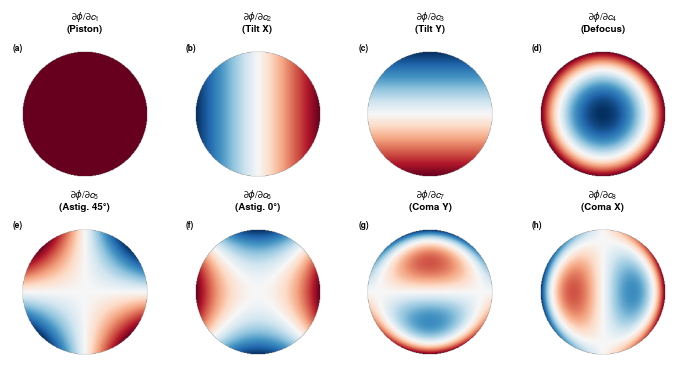

In [18]:
# Visualize gradient maps: how phase changes with each coefficient across the pupil
# The gradient dPhase/dCoeff_j is simply 2*pi * Z_j (the Zernike polynomial)

fig, axes = plt.subplots(2, 4, figsize=(7, 3.7))

mode_names = ["Piston", "Tilt X", "Tilt Y", "Defocus", 
              "Astig. 45°", "Astig. 0°", "Coma Y", "Coma X"]
subfig_labels = 'abcdefgh'

for idx, ax in enumerate(axes.flat):
    j = idx + 1  # Noll index
    n, m = noll_to_nm(j)
    n, m = int(n), int(m)
    
    # Gradient is 2*pi * normalized Zernike polynomial
    grad_map = 2 * jnp.pi * zernike_polynomial(rho_phys, theta_phys, n, m, normalize=True)
    grad_masked = jnp.where(rho_phys <= 1.0, grad_map, jnp.nan)
    
    vmax = jnp.nanmax(jnp.abs(grad_masked))
    if vmax > 0:
        im = ax.imshow(grad_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    else:
        im = ax.imshow(grad_masked, cmap="RdBu_r")
    
    ax.set_title(f"$\\partial\\phi / \\partial c_{{{j}}}$\n({mode_names[idx]})")
    ax.axis("off")
    ax.text(0.02, 0.98, f'({subfig_labels[idx]})', transform=ax.transAxes, 
            fontweight='bold', va='top', color='black')

plt.tight_layout()
plt.savefig('Figures/zernike_gradient_maps.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_gradient_maps.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

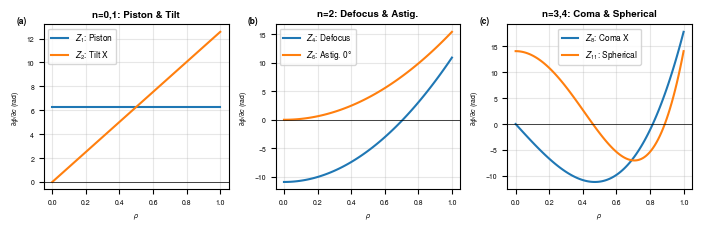

In [19]:
# Visualize how gradients change along a radial slice
# This shows the radial dependence of sensitivity to each coefficient

rho_slice = jnp.linspace(0, 1, 100)
theta_slice = 0.0  # Along x-axis

fig, axes = plt.subplots(1, 3, figsize=(7, 2.3))

# Group by radial order
groups = [
    ("n=0,1: Piston & Tilt", [(1, "Piston"), (2, "Tilt X")]),
    ("n=2: Defocus & Astig.", [(4, "Defocus"), (6, "Astig. 0°")]),
    ("n=3,4: Coma & Spherical", [(8, "Coma X"), (11, "Spherical")]),
]

subfig_labels = 'abc'

for idx, (ax, (title, modes)) in enumerate(zip(axes, groups)):
    for j, name in modes:
        n, m = noll_to_nm(j)
        n, m = int(n), int(m)
        Z = 2 * jnp.pi * zernike_polynomial(rho_slice, jnp.full_like(rho_slice, theta_slice), n, m, normalize=True)
        ax.plot(rho_slice, Z, label=f"$Z_{{{j}}}$: {name}", linewidth=1.5)
    
    ax.set_xlabel(r"$\rho$")
    ax.set_ylabel(r"$\partial\phi / \partial c$ (rad)")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5)
    ax.text(-0.15, 1.05, f'({subfig_labels[idx]})', transform=ax.transAxes, 
            fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('Figures/zernike_radial_sensitivity.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_radial_sensitivity.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

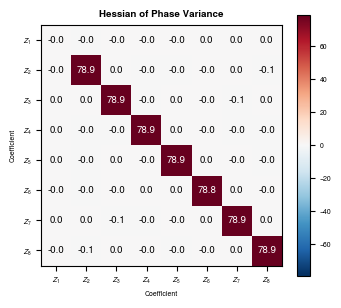

The diagonal Hessian shows how variance depends quadratically on each coefficient.
Off-diagonal terms are ~0 due to orthogonality of Zernike polynomials.


In [20]:
# Higher-order derivatives: Hessian of phase variance
# This demonstrates second-order differentiation capability

def compute_phase_map(coeffs):
    """Compute full phase map from coefficients."""
    phase = jnp.zeros_like(rho_phys)
    for j in range(1, len(coeffs) + 1):
        n, m = noll_to_nm(j)
        n, m = int(n), int(m)
        Z = zernike_polynomial(rho_phys, theta_phys, n, m, normalize=True)
        phase = phase + coeffs[j-1] * Z
    return 2 * jnp.pi * phase

def total_phase_variance(coeffs):
    """Compute variance of phase over the pupil."""
    phase = compute_phase_map(coeffs)
    mask = rho_phys <= 1.0
    phase_in_pupil = jnp.where(mask, phase, 0.0)
    n_pixels = jnp.sum(mask)
    mean_phase = jnp.sum(phase_in_pupil) / n_pixels
    variance = jnp.sum(jnp.where(mask, (phase - mean_phase)**2, 0.0)) / n_pixels
    return variance

# Compute Hessian
hessian_fn = jax.hessian(total_phase_variance)
coeffs_zero = jnp.zeros(8)
hessian_matrix = hessian_fn(coeffs_zero)

# Plot (single column width = 3.5")
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# Center colorbar around 0: use symmetric vmin/vmax
vmax_hess = float(jnp.max(jnp.abs(hessian_matrix)))
im = ax.imshow(hessian_matrix, cmap="RdBu_r", vmin=-vmax_hess, vmax=vmax_hess)

ax.set_xticks(range(8))
ax.set_yticks(range(8))
labels = [f"$Z_{{{j}}}$" for j in range(1, 9)]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Coefficient")
ax.set_ylabel("Coefficient")
ax.set_title("Hessian of Phase Variance")
plt.colorbar(im, ax=ax, shrink=0.8)

# Annotate
for i in range(8):
    for j in range(8):
        val = hessian_matrix[i, j]
        color = "white" if abs(val) > vmax_hess * 0.5 else "black"
        ax.text(j, i, f"{val:.1f}", ha="center", va="center", color=color, fontsize=7)

plt.tight_layout()
plt.savefig('Figures/zernike_hessian.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_hessian.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print("The diagonal Hessian shows how variance depends quadratically on each coefficient.")
print("Off-diagonal terms are ~0 due to orthogonality of Zernike polynomials.")

## Summary

This tutorial covered:

1. **Index conversion** between Noll and (n,m) indexing
2. **Radial polynomials** $R_n^{|m|}(\rho)$
3. **Individual Zernike polynomials** using `zernike_polynomial()`
4. **Zernike pyramid** organization by radial and azimuthal order
5. **Common aberrations**: defocus, astigmatism, coma, spherical, trefoil
6. **Generating aberrations** from coefficient arrays
7. **Coefficient variations** and their effects
8. **Orthogonality** verification
9. **Random aberrations** generation
10. **Differentiability**: gradients, Jacobians, and Hessians with JAX

### Key Functions

| Function | Description |
|----------|-------------|
| `noll_to_nm(j)` | Convert Noll index to (n, m) |
| `nm_to_noll(n, m)` | Convert (n, m) to Noll index |
| `zernike_polynomial(rho, theta, n, m)` | Generate single polynomial |
| `zernike_radial(rho, n, m)` | Radial component only |
| `generate_aberration_noll(xx, yy, coeffs, r)` | Phase from Noll coefficients |
| `generate_aberration_nm(xx, yy, n, m, coeffs, r)` | Phase from (n,m) coefficients |
| `defocus()`, `astigmatism()`, `coma()`, etc. | Convenience functions |

### Differentiability

All functions are compatible with JAX transformations:
- `jax.grad` - First derivatives
- `jax.jacfwd` / `jax.jacrev` - Jacobians
- `jax.hessian` - Second derivatives
- `jax.jit` - JIT compilation
- `jax.vmap` - Vectorization

## Publication Figure: Zernike Polynomials

A comprehensive figure for the Janssen paper showing:
- Individual Zernike modes (basis functions)
- Combined aberration from coefficients
- Gradient sensitivity (differentiability demonstration)

In [21]:
# Publication Figure: Computation
# Compute all data needed for the figure

import jax
import string
import optax

# Generate random aberration coefficients (the "unknown" aberration)
key = jax.random.PRNGKey(42)
n_coeffs = 15
aberration_coeffs = jax.random.normal(key, (n_coeffs - 3,)) * 0.3

# Create wrapper functions that use global rho, theta
def phase_rms_wrapper(coeffs):
    """Wrapper for phase_rms that uses global rho, theta."""
    return phase_rms(rho, theta, coeffs, start_noll=4)

def compute_phase_wrapper(coeffs):
    """Wrapper for compute_phase_from_coeffs that uses global rho, theta."""
    return compute_phase_from_coeffs(rho, theta, coeffs, start_noll=4)

# Blind correction: start with zero corrector coefficients
# The goal is to find corrector coefficients that cancel the aberration
# Total phase = aberration + corrector, we want to minimize RMS of total

def total_phase_rms(corrector_coeffs):
    """RMS of aberration + corrector (we want to minimize this)."""
    total_coeffs = aberration_coeffs + corrector_coeffs
    return phase_rms(rho, theta, total_coeffs, start_noll=4)

# Compute gradient of total RMS w.r.t. corrector coefficients
grad_total_rms = jax.grad(total_phase_rms)

# Start with zero corrector (blind start)
corrector_coeffs = jnp.zeros_like(aberration_coeffs)

# Run optimization loop
optimizer = optax.adam(learning_rate=0.05)
opt_state = optimizer.init(corrector_coeffs)

n_iterations = 50
midway_iter = 5  # Iteration to show intermediate state
rms_history = [float(total_phase_rms(corrector_coeffs))]

# Track midway state
corrector_at_midway = None
rms_at_midway = None

for i in range(n_iterations):
    grads = grad_total_rms(corrector_coeffs)
    updates, opt_state = optimizer.update(grads, opt_state)
    corrector_coeffs = optax.apply_updates(corrector_coeffs, updates)
    rms_history.append(float(total_phase_rms(corrector_coeffs)))
    
    # Save state at midway iteration
    if i == midway_iter - 1:  # After midway_iter iterations (0-indexed)
        corrector_at_midway = corrector_coeffs.copy()
        rms_at_midway = rms_history[-1]

final_corrector = corrector_coeffs
final_total_coeffs = aberration_coeffs + final_corrector

# Compute phases
phase_aberration = compute_phase_wrapper(aberration_coeffs)
phase_corrected = compute_phase_wrapper(final_total_coeffs)

# Compute midway phase
total_coeffs_at_midway = aberration_coeffs + corrector_at_midway
phase_midway = compute_phase_wrapper(total_coeffs_at_midway)

# Compute RMS values
phase_masked = jnp.where(rho <= 1.0, phase_aberration, jnp.nan)
vmax_random = float(jnp.nanmax(jnp.abs(phase_masked)))
rms_initial = rms_history[0]
rms_final = rms_history[-1]

# Prepare data for bar plots
coeff_indices = list(range(4, 16))
aberration_values_plot = [float(aberration_coeffs[j-4]) for j in coeff_indices]
corrector_values_plot = [float(final_corrector[j-4]) for j in coeff_indices]
corrector_at_midway_values_plot = [float(corrector_at_midway[j-4]) for j in coeff_indices]
final_total_values_plot = [float(final_total_coeffs[j-4]) for j in coeff_indices]

print(f"Blind correction complete.")
print(f"Initial RMS (aberration only): {rms_initial:.3f} rad")
print(f"RMS at iteration {midway_iter}: {rms_at_midway:.3f} rad")
print(f"Final RMS (aberration + corrector): {rms_final:.3f} rad")
print(f"RMS reduction: {(rms_initial - rms_final) / rms_initial * 100:.1f}%")

Blind correction complete.
Initial RMS (aberration only): 5.841 rad
RMS at iteration 5: 2.973 rad
Final RMS (aberration + corrector): 0.146 rad
RMS reduction: 97.5%


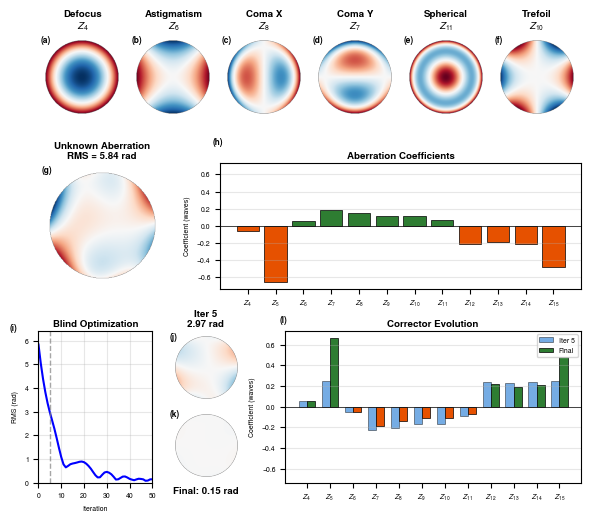

In [22]:
# Publication Figure: Plotting
# IEEE double-column format (7 inches wide)

# Subfigure counter
subfig_counter = 0

def get_subfig_label():
    """Get next subfigure label and increment counter."""
    global subfig_counter
    label = f'({string.ascii_lowercase[subfig_counter]})'
    subfig_counter += 1
    return label

def plot_zernike_pub(rho, theta, n, m, ax, title=None):
    """Plot a Zernike polynomial for publication."""
    Z = zernike_polynomial(rho, theta, n, m, normalize=True)
    Z_masked = jnp.where(rho <= 1.0, Z, jnp.nan)
    vmax = jnp.nanmax(jnp.abs(Z_masked))
    im = ax.imshow(Z_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax, 
                   extent=[-1.2, 1.2, -1.2, 1.2])
    ax.set_aspect("equal")
    ax.axis("off")
    if title:
        ax.set_title(title, pad=3)
    ax.text(0.02, 0.98, get_subfig_label(), transform=ax.transAxes, 
            fontweight='bold', va='top', ha='left')
    return im

def plot_phase_pub(phase, ax, title, vmax_override=None, title_below=False):
    """Plot phase map for publication."""
    phase_masked = jnp.where(rho <= 1.0, phase, jnp.nan)
    if vmax_override is not None:
        vmax = vmax_override
    else:
        vmax = jnp.nanmax(jnp.abs(phase_masked))
    im = ax.imshow(phase_masked, cmap="RdBu_r", vmin=-vmax, vmax=vmax,
                   extent=[-1.2, 1.2, -1.2, 1.2])
    ax.set_aspect("equal")
    ax.axis("off")
    if title_below:
        # Use text annotation below the axes since axis("off") hides xlabel
        ax.text(0.5, -0.05, title, transform=ax.transAxes,
                fontweight='bold', va='top', ha='center', fontsize=7)
    else:
        ax.set_title(title, pad=3)
    ax.text(0.02, 0.98, get_subfig_label(), transform=ax.transAxes,
            fontweight='bold', va='top', ha='left')
    return im

# Create combined figure
fig = plt.figure(figsize=(7, 6))
gs = mpgs.GridSpec(36, 42, figure=fig, hspace=0.3, wspace=0.3)

# Bar plot colors: green for positive, orange for negative
COLOR_POS = '#2E7D32'  # Dark green
COLOR_NEG = '#E65100'  # Dark orange
COLOR_MIDWAY = '#1976D2'   # Blue for midway iteration

# Compute symmetric y-axis limits for both bar plots
max_abs_coeff = max(
    max(abs(v) for v in aberration_values_plot),
    max(abs(v) for v in corrector_values_plot),
    max(abs(v) for v in corrector_at_midway_values_plot)
)
bar_ylim = (-max_abs_coeff * 1.1, max_abs_coeff * 1.1)

# ============ Section 1: Individual Zernike modes (a-f) ============
modes = [
    (2, 0, "Defocus"),
    (2, 2, "Astigmatism"),
    (3, 1, "Coma X"),
    (3, -1, "Coma Y"),
    (4, 0, "Spherical"),
    (3, 3, "Trefoil"),
]

for idx, (n, m, name) in enumerate(modes):
    col_start = int(idx * 7)
    ax = fig.add_subplot(gs[0:9, col_start:col_start+7])
    j = nm_to_noll(n, m)
    plot_zernike_pub(rho, theta, n, m, ax, title=f'{name}\n$Z_{{{j}}}$')

# ============ Section 2: Aberration + Coefficients (g-h) ============
ax_aberration = fig.add_subplot(gs[11:21, 0:10])
im = ax_aberration.imshow(jnp.where(rho <= 1.0, phase_aberration, jnp.nan), cmap="RdBu_r", 
                      vmin=-vmax_random, vmax=vmax_random, extent=[-1.2, 1.2, -1.2, 1.2])
ax_aberration.set_aspect("equal")
ax_aberration.axis("off")
ax_aberration.set_title(f"Unknown Aberration\nRMS = {rms_initial:.2f} rad", pad=3)
ax_aberration.text(0.02, 0.98, get_subfig_label(), transform=ax_aberration.transAxes,
               fontweight='bold', va='top', ha='left')

ax_bar = fig.add_subplot(gs[11:21, 14:42])
coeff_labels_plot = [f"$Z_{{{j}}}$" for j in coeff_indices]
coeff_colors = [COLOR_POS if v >= 0 else COLOR_NEG for v in aberration_values_plot]
bars = ax_bar.bar(range(len(aberration_values_plot)), aberration_values_plot,
                  color=coeff_colors, edgecolor='black', linewidth=0.5)
ax_bar.set_xticks(range(len(aberration_values_plot)))
ax_bar.set_xticklabels(coeff_labels_plot)
ax_bar.set_ylabel("Coefficient (waves)")
ax_bar.axhline(y=0, color='k', linewidth=0.5)
ax_bar.grid(True, alpha=0.3, axis='y')
ax_bar.set_title("Aberration Coefficients", pad=3)
ax_bar.set_ylim(bar_ylim)
ax_bar.text(-0.02, 1.20, get_subfig_label(), transform=ax_bar.transAxes,
            fontweight='bold', va='top', ha='left')

# ============ Section 3: RMS vs iteration + Two corrected phases + Corrector evolution (i-l) ===========

# RMS vs iteration
ax_rms_iter = fig.add_subplot(gs[24:36, 0:9])
ax_rms_iter.plot(range(len(rms_history)), rms_history, 'b-', linewidth=1.5)
ax_rms_iter.axvline(x=midway_iter, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax_rms_iter.set_xlabel("Iteration")
ax_rms_iter.set_ylabel("RMS (rad)")
ax_rms_iter.set_title("Blind Optimization", pad=3)
ax_rms_iter.grid(True, alpha=0.3)
ax_rms_iter.set_xlim(0, len(rms_history)-1)
ax_rms_iter.set_ylim(0, max(rms_history) * 1.1)
ax_rms_iter.text(-0.25, 1.05, get_subfig_label(), transform=ax_rms_iter.transAxes,
         fontweight='bold', va='top', ha='left')

# Midway phase (at iteration 5)
ax_midway = fig.add_subplot(gs[24:30, 10:16])
plot_phase_pub(phase_midway, ax_midway, f"Iter {midway_iter}\n{rms_at_midway:.2f} rad", 
               vmax_override=vmax_random)

# Corrected phase (final) - title below to avoid overlap with (j)
ax_corrected = fig.add_subplot(gs[30:36, 10:16])
plot_phase_pub(phase_corrected, ax_corrected, f"Final: {rms_final:.2f} rad", 
               vmax_override=vmax_random, title_below=True)

# Corrector evolution: midway vs final (side by side bars)
ax3 = fig.add_subplot(gs[24:36, 19:42])
x_positions = range(len(corrector_values_plot))
bar_width = 0.35

# Midway iteration bars (lighter, behind)
bars_midway = ax3.bar([x - bar_width/2 for x in x_positions], corrector_at_midway_values_plot, 
                   bar_width, color=COLOR_MIDWAY, alpha=0.6, edgecolor='black', 
                   linewidth=0.5, label=f'Iter {midway_iter}')

# Final bars (in front)
corrector_colors = [COLOR_POS if c >= 0 else COLOR_NEG for c in corrector_values_plot]
bars_final = ax3.bar([x + bar_width/2 for x in x_positions], corrector_values_plot, 
                      bar_width, color=corrector_colors, edgecolor='black', 
                      linewidth=0.5, label='Final')

ax3.set_xticks(x_positions)
ax3.set_xticklabels(coeff_labels_plot)
ax3.set_ylabel("Coefficient (waves)")
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_title("Corrector Evolution", pad=3)
ax3.set_ylim(bar_ylim)
ax3.legend(loc='upper right', fontsize=5)
ax3.text(-0.02, 1.1, get_subfig_label(), transform=ax3.transAxes,
         fontweight='bold', va='top', ha='left')

plt.savefig('Figures/zernike_publication_figure.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/zernike_publication_figure.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()